In [1]:
#Loads some parameters
import CloudDataset128c
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.transforms.v2 as v2
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 7

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


In [ ]:
#Loads some parameters
import CloudDataset128c
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.transforms.v2 as v2
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 7

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([7, 12, 128, 128])
torch.Size([7, 6, 128, 128])


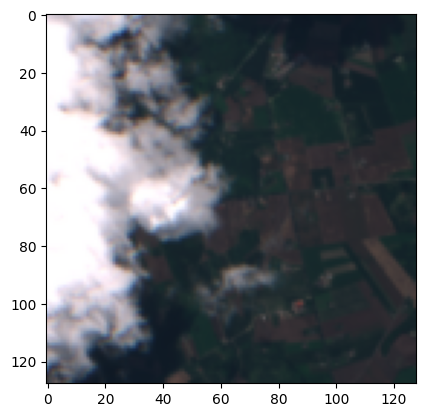

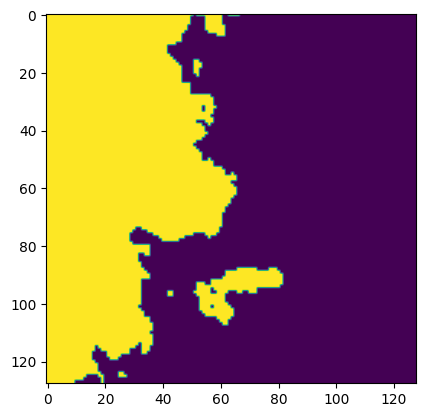

In [2]:
transform = {
    "image": v2.Compose([
    transforms.Resize(size=(256,256)),
]),
    "mask": v2.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset128c.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels,_ = next(it)

print(type(images))
print(images.shape)
print(labels.shape)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

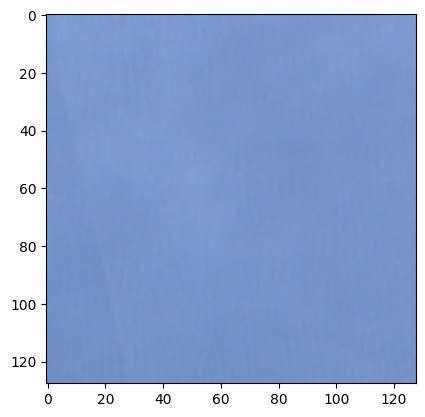

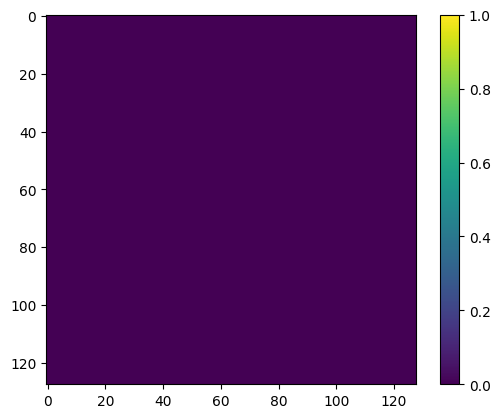

In [3]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels,_ = next(it)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
img = plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0,vmax=1)
plt.colorbar(img)
plt.show()

In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 128x128x12
        self.e11 = nn.Conv2d(12, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x512

        # input: 8x8x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 4x4x1024

        # input: 4x4x1024
        self.e61 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # output: 4x4x2048
        self.e62 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1) # output: 4x4x2048


        # Decoder
        # input: 4x4x2048
        self.upconv0 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2) # output: 8x8x2048
        self.d01 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.d02 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024


        # input: 8x8x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 16x16x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512

        # input: 16x16x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 32x32x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256

        # input: 32x32x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x64x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128

        # input: 64x64x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x128x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64

        # Output layer
        # input: 128x128x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 128 x 128 x n_class

        #Dropout
        self.dropout = nn.Dropout(0.85)
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)
        xp5 = self.pool5(xe52)
        #print(xp5.shape)

        xe61 = relu(self.e61(xp5))
        #print(xe51.shape)
        xe62 = relu(self.e62(xe61))
        #print(xe52.shape)
        
        # Decoder
        xu0 = self.upconv0(xe62)
        xu01 = torch.cat([xu0, xe52], dim=1)
        xd01 = relu(self.d01(xu01))
        xd02 = relu(self.d02(xd01))

        xu1 = self.upconv1(xd02)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 2.9287545999977738 Time_diff: 2.9287553999893134 loss: 1.716915249824524
Epoch: 0 batch_nr: 8 Time: 66.18064459999732 Time_diff: 7.831091799991555 loss: 1.998922997050815
new val loss: 2.795186996459961
Epoch: 1 batch_nr: 7 Time: 142.9815060999972 Time_diff: 7.641639800000121 loss: 1.9166888892650604
new val loss: 1.290291428565979
Epoch: 2 batch_nr: 6 Time: 219.60996849999356 Time_diff: 8.042226600009599 loss: 1.723970583506993
new val loss: 5.877074718475342
Epoch: 3 batch_nr: 5 Time: 294.19876790000126 Time_diff: 7.757480799991754 loss: 1.7615541815757751
new val loss: 44.224143981933594
Epoch: 4 batch_nr: 4 Time: 373.80785820000165 Time_diff: 7.8088149999966845 loss: 1.7643704652786254
new val loss: 2.4622275829315186
Epoch: 5 batch_nr: 3 Time: 450.07913089999056 Time_diff: 7.620937900006538 loss: 1.602859914302826

 New best loss: 0.9552135467529297


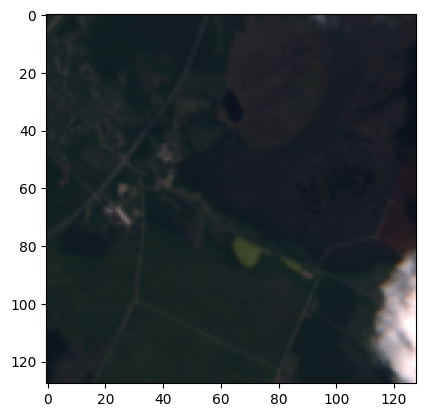

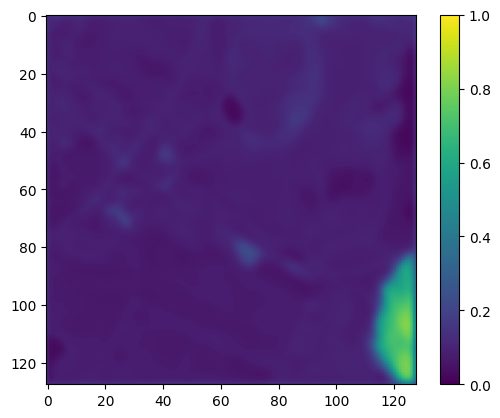

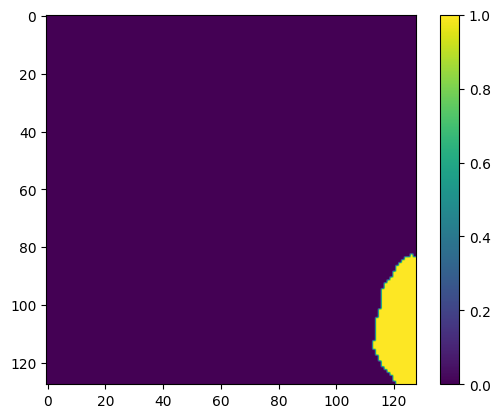

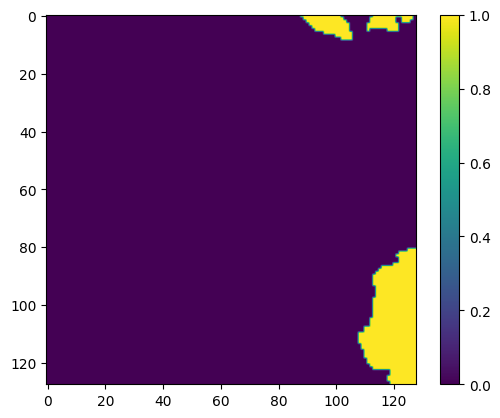

Epoch: 6 batch_nr: 2 Time: 528.5105441999913 Time_diff: 7.829054100002395 loss: 1.7657409111658733
Epoch: 6 batch_nr: 10 Time: 588.4551147999882 Time_diff: 5.007359399998677 loss: 1.5356722419912165
new val loss: 1.3657253980636597
Epoch: 7 batch_nr: 1 Time: 605.1077562999999 Time_diff: 7.729773300001398 loss: 1.3576411604881287
Epoch: 7 batch_nr: 9 Time: 668.3154538999952 Time_diff: 7.937182400011807 loss: 1.6769726753234864
new val loss: 2.1749234199523926
Epoch: 8 batch_nr: 0 Time: 682.4762350999954 Time_diff: 9.00559690000955 loss: 1.3190468549728394
Epoch: 8 batch_nr: 8 Time: 746.2545136999979 Time_diff: 7.757480399988708 loss: 1.5579349994659424
new val loss: 0.9929662346839905
Epoch: 9 batch_nr: 7 Time: 821.3000714999944 Time_diff: 7.758238499998697 loss: 1.5227138698101044
new val loss: 7.975322246551514
Epoch: 10 batch_nr: 6 Time: 897.4006171999936 Time_diff: 7.405547200003639 loss: 1.5451257569449288
new val loss: 1.2722899913787842
Epoch: 11 batch_nr: 5 Time: 971.32702929999

KeyboardInterrupt: 

In [5]:
import copy
from time import perf_counter
import random

epochs=500

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0


    best_loss = 1.2

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels) in enumerate(train_loader):
            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%8==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
        
        #Grabs next iterator batch, restarts if at end of iterator
        try:
            images_valid, labels_valid = next(iterator)
        except:
            iterator = iter(val_loader)
            images_valid, labels_valid = next(iterator)


        #Forward - Validation
        predictions = model(images_valid)
        v_loss = criterion(predictions,labels_valid.float())
        
        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append(v_loss.item())

        #Finds best model
        if (v_loss<best_loss):
            best_loss=v_loss.item()
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET128_model.pt')
            print("\n New best loss:",best_loss)

            
            plt.figure()
            plt.imshow(images_valid[0][:3].permute(1,2,0))
            plt.show()
            
            i=4

            predictions_softmax = nn.Softmax(dim=1)(predictions.detach())

            plt.figure()
            img=plt.imshow(predictions_softmax[0][i:i+1][:3].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()

            a = predictions_softmax.argmax (1)
            predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

            plt.figure()
            img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels_valid[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
        else:
            print("new val loss:",v_loss.item())
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = torch.load("best_UNET128c_model.pt")
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]))

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [24]:
def from_one_hot(label):
    return np.argmax(label,0,keepdims=True)

test_dataset = CloudDataset128c.CloudDataset("data\\train",transform=transform)
batch_size=1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET128c_model.pt")
criterion = nn.CrossEntropyLoss()
predictions = best_model(images)

In [25]:
it = iter(test_loader)

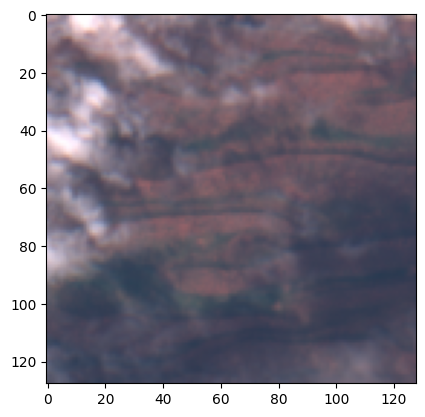

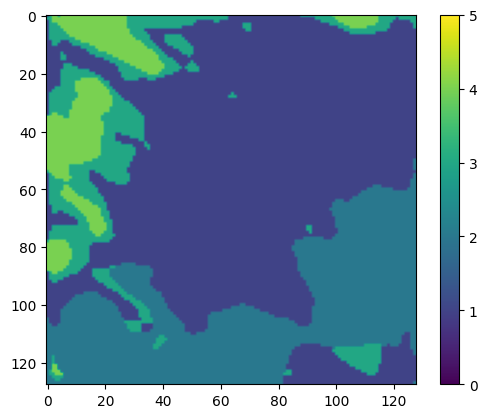

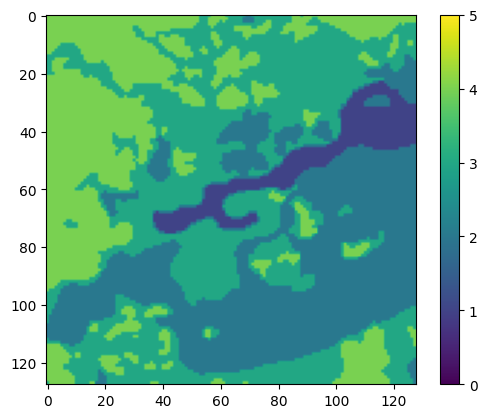

In [69]:
images,labels,images_disp = next(test_it)
predictions = best_model(images)
plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


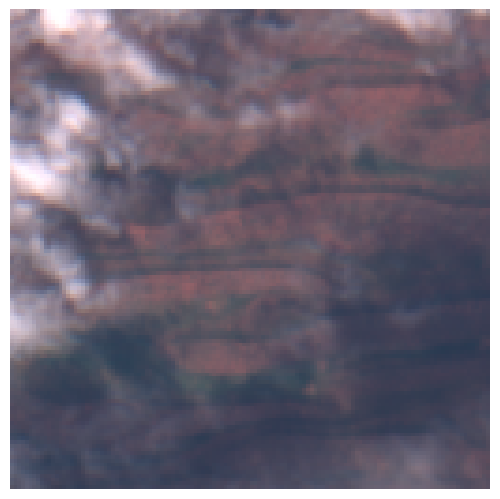

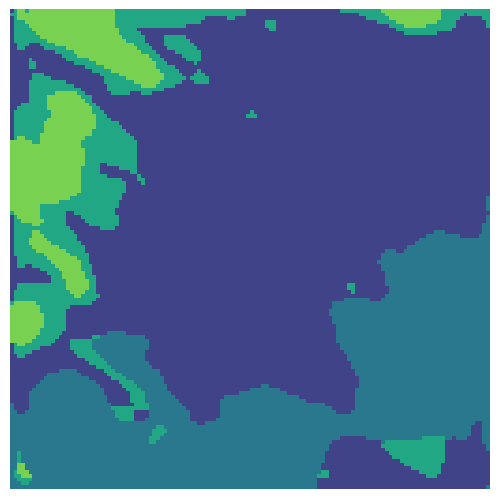

loss: tensor(1.2777, grad_fn=<DivBackward1>)


In [70]:



predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img4.png', bbox_inches='tight',pad_inches=0)
plt.show()

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img = ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0,vmax=5)
plt.savefig('pred4.png', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))

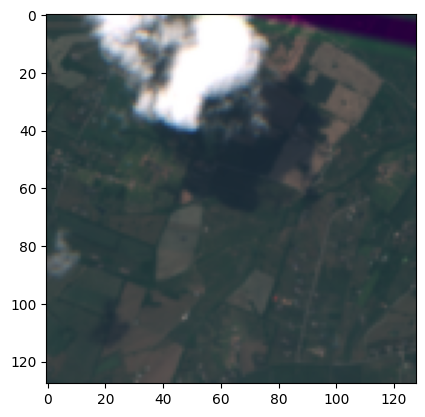

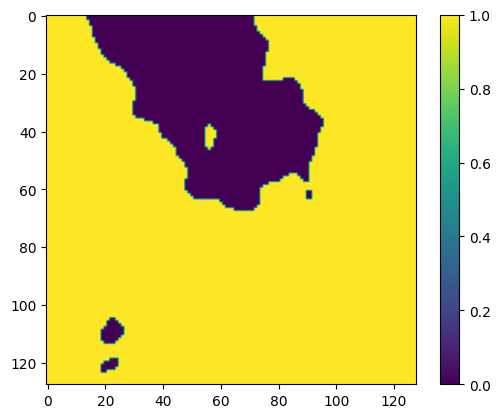

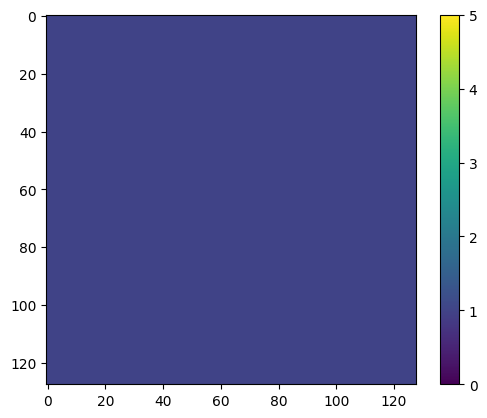

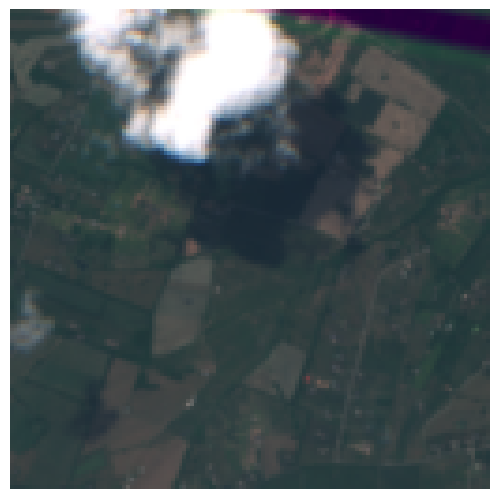

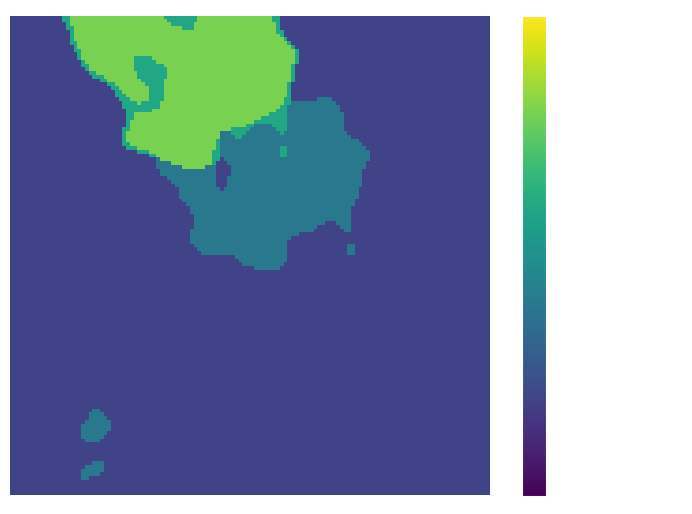

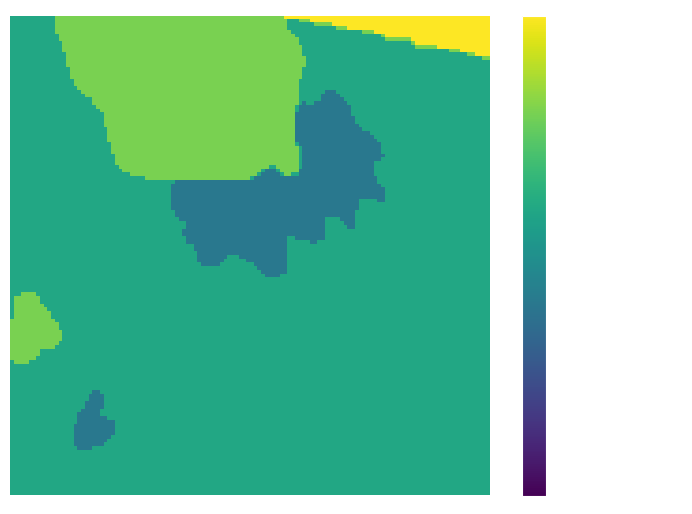

loss: tensor(1.2729, grad_fn=<DivBackward1>)


In [29]:


plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
i=1

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

plt.figure()
img=plt.imshow(torch.ones_like(predictions_binary[0][i:i+1]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img3.png', bbox_inches='tight',pad_inches=0)
plt.show()

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img = ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0,vmax=5)
cb=plt.colorbar(img,ticks=[0,1,2,3,4,5])
cb.ax.set_yticklabels(['Undefined','Clear','Cloud Shadow','Transparent Cloud','Cloud','Missing'])
fg_color ="white"
cb.ax.yaxis.set_tick_params(color=fg_color)
cb.outline.set_edgecolor(fg_color)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)
plt.savefig('pred3.png', bbox_inches='tight',pad_inches=0)
plt.show()

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img = ax.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0,vmax=5)
cb=plt.colorbar(img,ticks=[0,1,2,3,4,5])
cb.ax.set_yticklabels(['Undefined','Clear','Cloud Shadow','Transparent Cloud','Cloud','Missing'])
fg_color ="white"
cb.ax.yaxis.set_tick_params(color=fg_color)
cb.outline.set_edgecolor(fg_color)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)
plt.savefig('lab3.png', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))

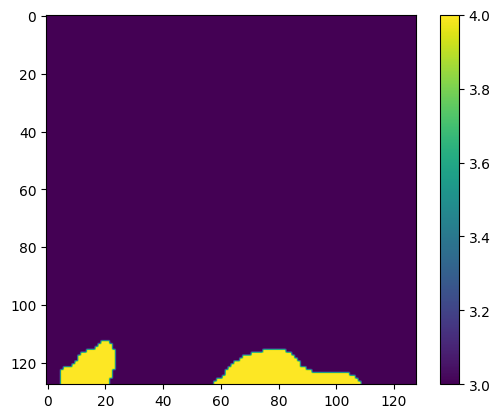

In [10]:


l = (from_one_hot(labels[0]))

plt.figure()
img=plt.imshow(l.permute(1,2,0))
plt.colorbar(img)
plt.show()

In [2]:
images,labels = next(test_it)
predictions = best_model(images)

NameError: name 'test_it' is not defined

In [1]:
images,labels = next(test_it)
predictions = best_model(images)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

NameError: name 'test_it' is not defined

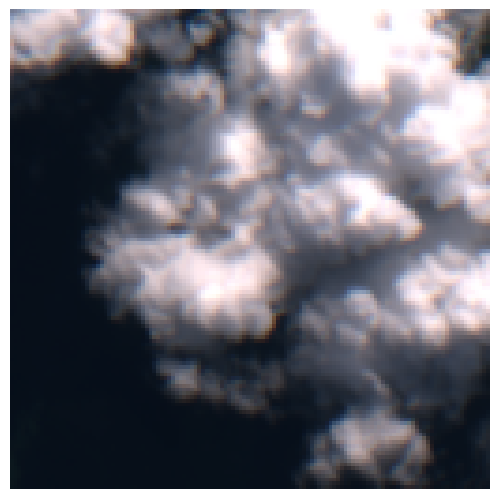

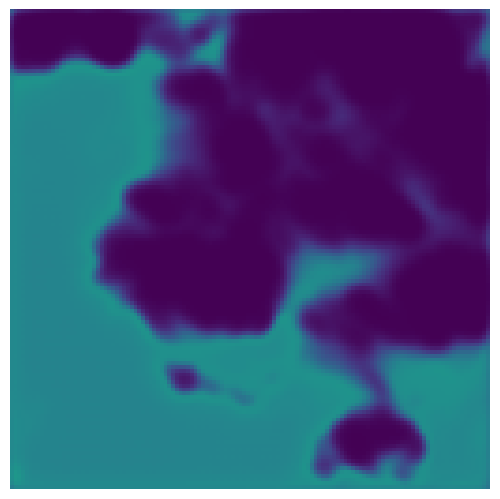

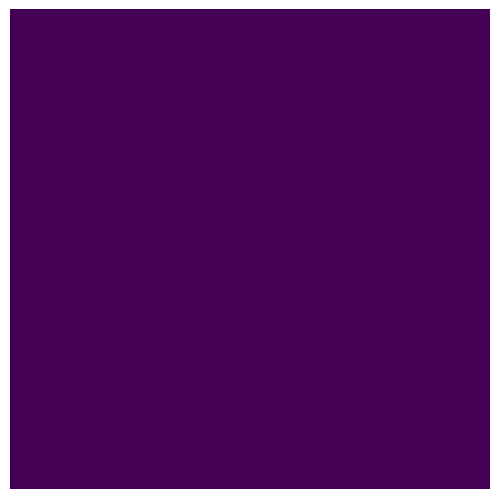

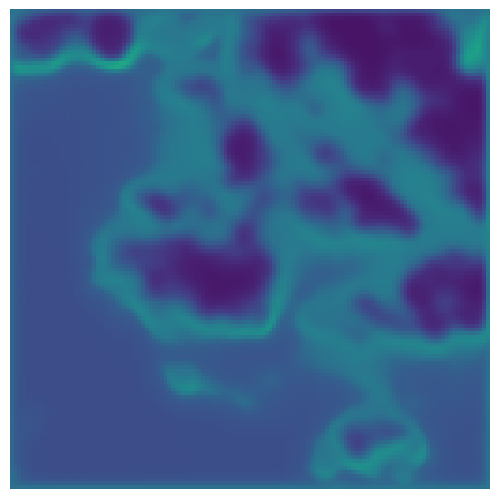

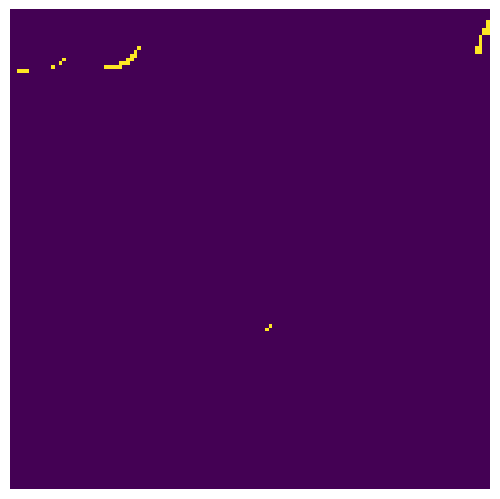

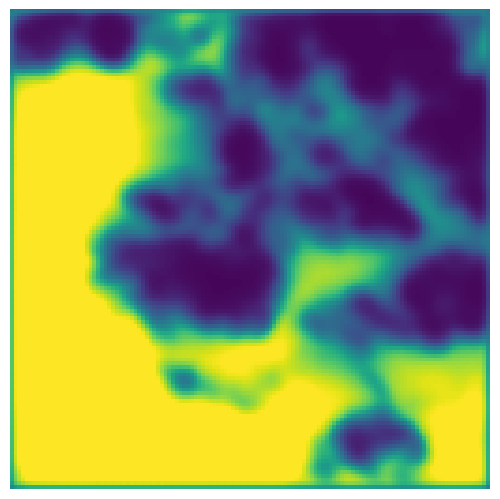

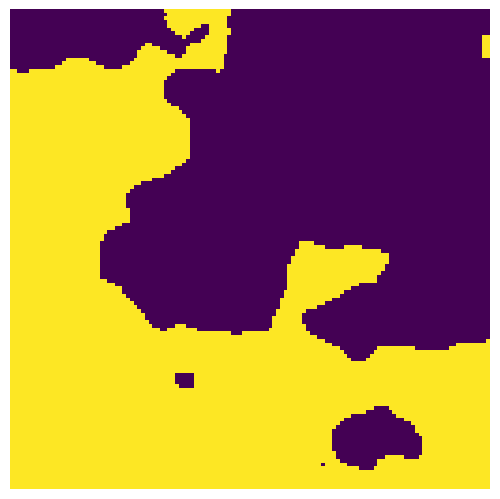

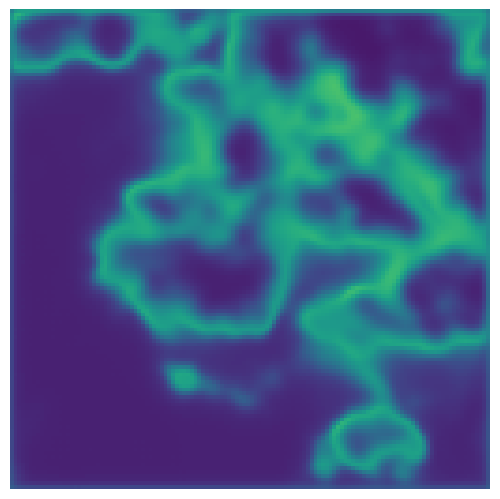

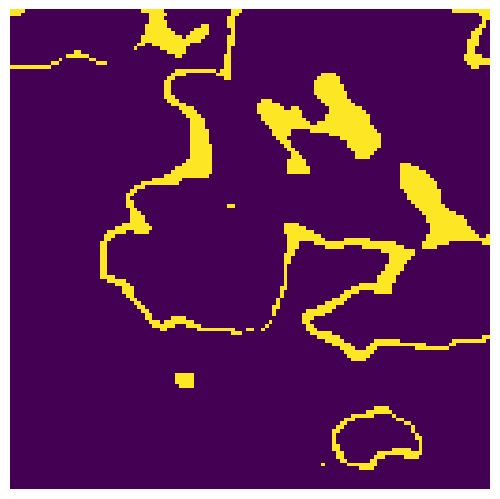

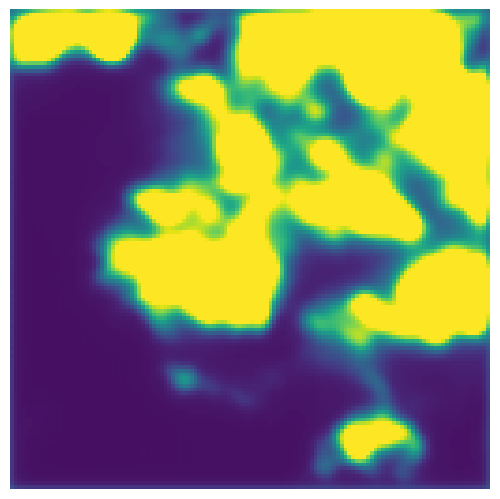

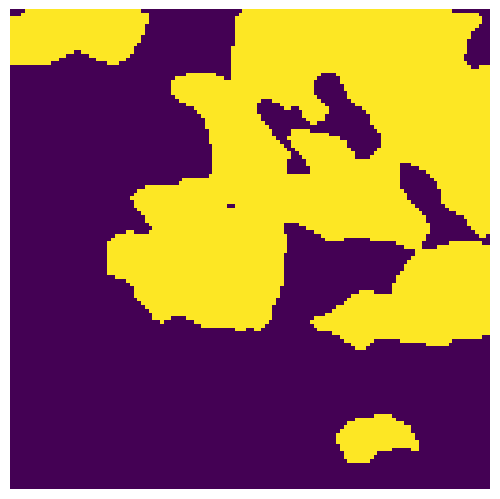

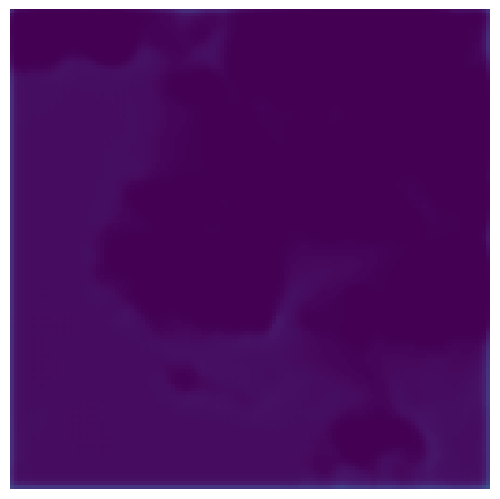

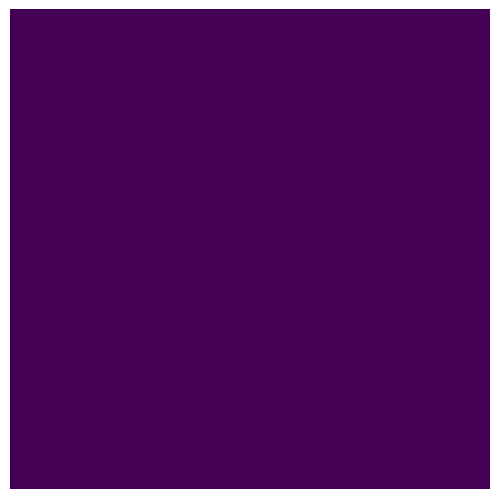

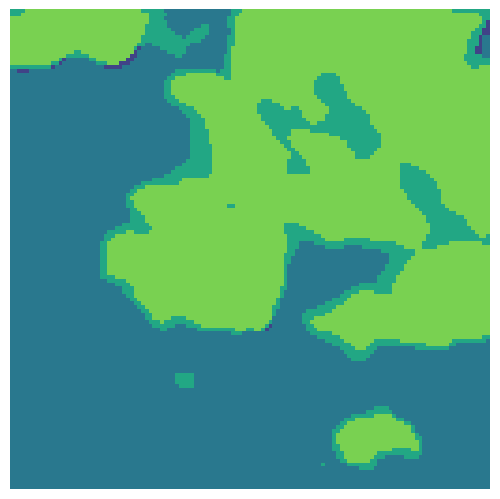

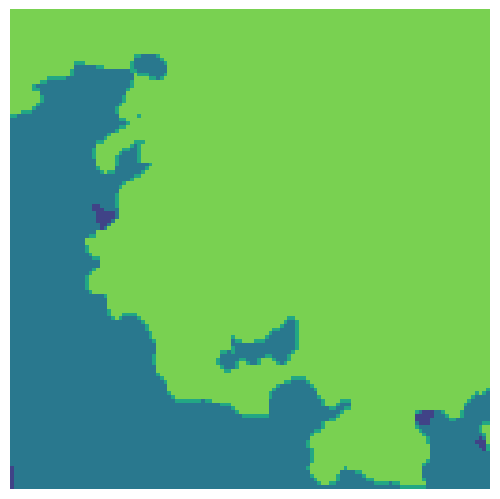

loss: tensor(1.0568, grad_fn=<DivBackward1>)


In [50]:
#For creating images

predictions = best_model(images)

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

for i in range(6):

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_softmax[0][i:i+1].permute(1,2,0),vmin=0, vmax=0.5)
    plt.savefig('softmax'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
    plt.savefig('binary'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()



fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('predictions.jpg', bbox_inches='tight',pad_inches=0)
plt.show()


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('label.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))


In [63]:
_,labels = next(iter(training_loader))

In [81]:

vs = [0,0,0,0,0,0]
total=0
for batch_nr, (_,labels) in enumerate(training_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
for batch_nr, (_,labels) in enumerate(validation_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
print(vs)
m = max(vs)
for i, e in enumerate(vs):
    vs[i]=m/e
print(vs)

[830, 521225, 199987, 339080, 326761, 70293]
[627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]


In [11]:
#Evaluate
total = 0
correct = 0

for batch_nr, (images, labels) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        y = torch.sum((pred==label))
        correct += y
        total += 128*128
        i+=1

print("Accuracy =", correct/total)

    

Accuracy = tensor(0.5783)


In [13]:
# IoU calculation

Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        for p_class in range(6):
            inter=torch.sum((pred==label)*(label==p_class))
            uni = (torch.sum((label==p_class)) + torch.sum((label==p_class)) - inter)
            Intersection[p_class] += inter.item()
            Union[p_class] += uni.item()
        i+=1

for p_class in range(6):
    try:
        print("IoU, class=",p_class,":",Intersection[p_class]/Union[p_class])
    except:
        print("IoU, class=",p_class,":","NAN (Union=0)")

IoU, class= 0 : 0.0
IoU, class= 1 : 0.47990792787202263
IoU, class= 2 : 0.37283947435397663
IoU, class= 3 : 0.13801988257715372
IoU, class= 4 : 0.618909068943299
IoU, class= 5 : 0.9694409703376832


In [16]:
#Confusion matrix
CM = [[0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0]]


Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels,_) in enumerate(training_loader):

      predictions = best_model(images)

      predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
      predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

      i=0
      while i<len(predictions):
            pred = from_one_hot(predictions_binary[i])
            label = from_one_hot(labels[i])

            for a_class in range(6):
                  for p_class in range(6):
                        CM[a_class][p_class] += torch.sum((pred==p_class)*(label==a_class)).item()
            i+=1
      print(batch_nr)

print(CM)

0
1
2
3
4
5
6
7
8
9
10
[[0, 27, 336, 20, 13, 0], [0, 279776, 48914, 58471, 42775, 2944], [0, 34996, 73721, 10401, 46923, 0], [0, 113315, 24647, 72820, 76679, 0], [0, 16606, 22891, 22119, 172392, 152], [0, 3, 0, 0, 0, 42323]]


In [17]:

for row in CM:
    for col in row:
        print(col, end="\t")
    print()
print()
for row in CM:
    sm = sum(row)
    for col in row:
        print(f"{col*100/sm:.0f}", end="\t")
    print()
print()
for row in CM:
    for i, col in enumerate(row):
        sm = [ sum(x) for x in zip(*CM) ]
        print(f"{col*100/sm[i]:.0f}", end="\t")
    print()

0	27	336	20	13	0	
0	279776	48914	58471	42775	2944	
0	34996	73721	10401	46923	0	
0	113315	24647	72820	76679	0	
0	16606	22891	22119	172392	152	
0	3	0	0	0	42323	

0	7	85	5	3	0	
0	65	11	14	10	1	
0	21	44	6	28	0	
0	39	9	25	27	0	
0	7	10	9	74	0	
0	0	0	0	0	100	



ZeroDivisionError: division by zero